In [1]:
import itertools
from copy import deepcopy as copy

import cvxpy as cp
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy

from Span import SpanProgram, sdp_to_span
from Adversary import Adversary, Problem, to_str, visualize
from ElementDistinctness import ED
from Examples import exact_k, threshold_k
from Solvers import adv_solver, span_solver2, big_mask_index_disagree, big_mask_index_disagree_type, big_mask_instance

mpl.rcParams["figure.dpi"] = 200

In [2]:
def span_solver(problem, solver_params=None, mode=None, target=None):
    if target is None:
        target = np.ones(problem.yes_len)
    if solver_params is None:
        solver_params = {"solver": "MOSEK", "verbose": True}
    lang_size = problem.yes_len + problem.no_len
    n = problem.n
    mat_size = lang_size * n
    X = cp.Variable((mat_size, mat_size), PSD=True)
    Y = None
    t = cp.Variable()
    I = np.identity(mat_size)
    constraints = []

    constraints += [
        cp.sum(cp.multiply(big_mask_index_disagree_type(problem, yes_i, no_i), X)) == 1
        for yes_i, no_i in itertools.product(
            problem.yes_instances, problem.no_instances
        )
    ]

    constraints += [
        cp.trace(cp.multiply(big_mask_instance(problem, instance), X)) <= t
        for instance in problem.no_instances + problem.yes_instances
    ]
    
   
    prob = cp.Problem(cp.Minimize(t), constraints)
    prob.solve(**solver_params)
    if Y is not None:
        return prob.value, X.value, Y.value

    return prob.value, X.value

28 8 36
                                     CVXPY                                     
                                     v1.4.2                                    
(CVXPY) May 13 07:22:34 PM: Your problem has 82945 variables, 260 constraints, and 0 parameters.
(CVXPY) May 13 07:22:34 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) May 13 07:22:34 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) May 13 07:22:34 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) May 13 07:22:34 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) May 13 07:22:34 PM: Compiling problem (target solve

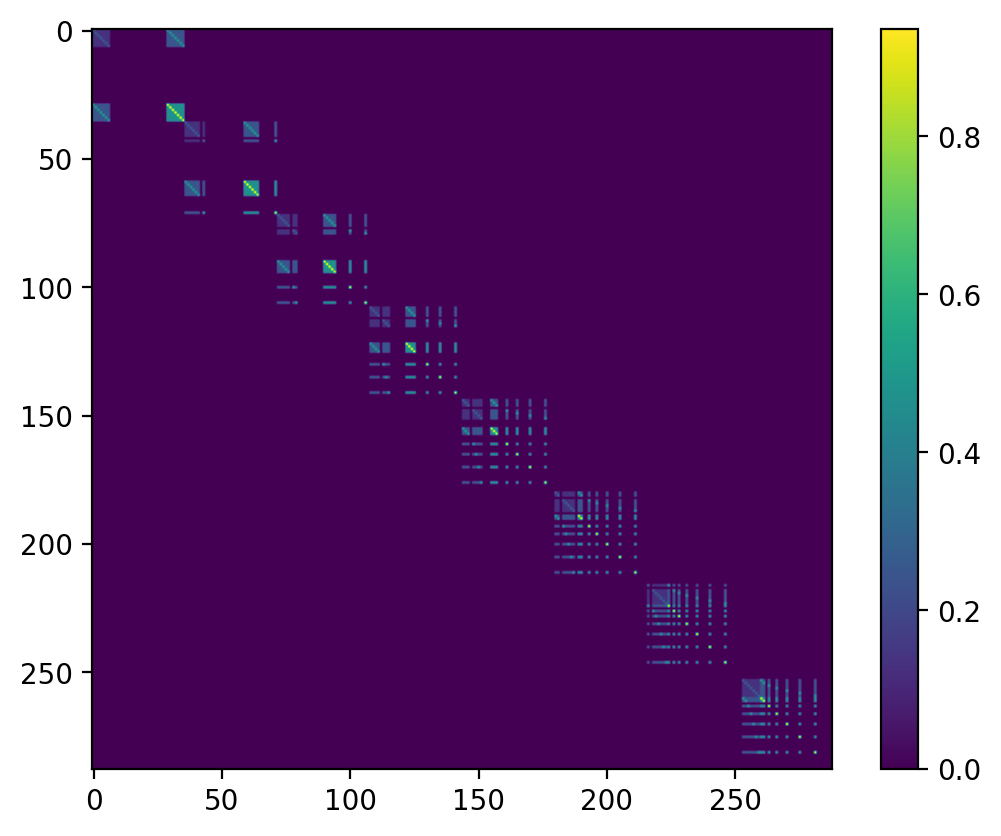

0.935414291400909
[(0, 0, 1, 0, 0, 0, 0, 0), (0, 0, 0, 0, 0, 1, 0, 0), (1, 0, 0, 0, 0, 0, 0, 0), (0, 0, 0, 0, 1, 0, 0, 0), (0, 0, 0, 0, 0, 0, 1, 0), (0, 0, 0, 1, 0, 0, 0, 0), (0, 0, 0, 0, 0, 0, 0, 1), (0, 1, 0, 0, 0, 0, 0, 0), (0, 0, 0, 1, 0, 0, 0, 1), (0, 0, 0, 0, 1, 0, 1, 0), (0, 0, 0, 0, 1, 1, 0, 0), (0, 0, 0, 1, 0, 1, 0, 0), (0, 1, 0, 0, 0, 0, 0, 1), (0, 1, 1, 0, 0, 0, 0, 0), (0, 1, 0, 0, 0, 1, 0, 0), (1, 0, 1, 0, 0, 0, 0, 0), (0, 0, 0, 0, 1, 0, 0, 1), (1, 0, 0, 0, 0, 0, 1, 0), (1, 1, 0, 0, 0, 0, 0, 0), (0, 0, 1, 0, 1, 0, 0, 0), (1, 0, 0, 0, 0, 0, 0, 1), (0, 0, 1, 0, 0, 0, 1, 0), (1, 0, 0, 1, 0, 0, 0, 0), (0, 0, 0, 0, 0, 0, 1, 1), (0, 0, 1, 0, 0, 0, 0, 1), (1, 0, 0, 0, 1, 0, 0, 0), (0, 0, 1, 0, 0, 1, 0, 0), (0, 1, 0, 0, 0, 0, 1, 0), (0, 1, 0, 1, 0, 0, 0, 0), (0, 0, 0, 1, 0, 0, 1, 0), (1, 0, 0, 0, 0, 1, 0, 0), (0, 0, 0, 1, 1, 0, 0, 0), (0, 0, 1, 1, 0, 0, 0, 0), (0, 1, 0, 0, 1, 0, 0, 0), (0, 0, 0, 0, 0, 1, 0, 1), (0, 0, 0, 0, 0, 1, 1, 0)]
[(0, 0, 1, 0, 0, 0, 0, 0), (0, 0, 0, 0, 0, 1,

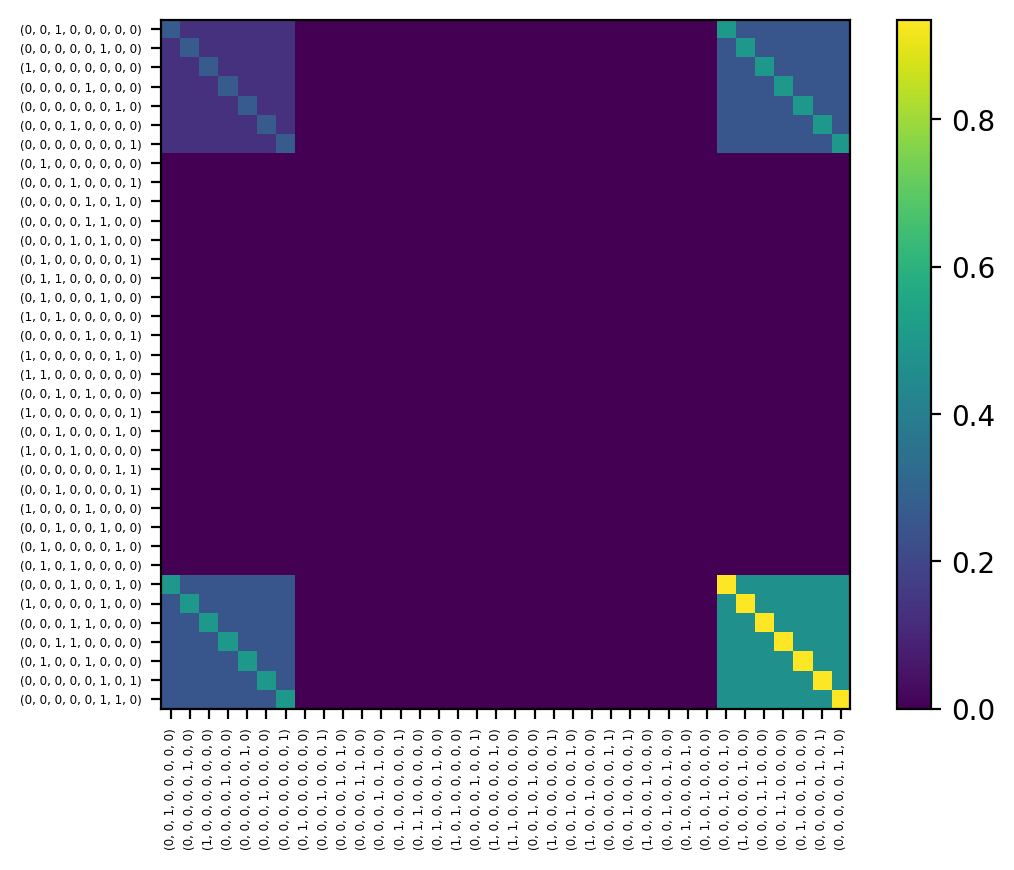

In [4]:
diffs = []
# prob = ED(3)
prob = threshold_k(8, 2)
print(prob.yes_len, prob.no_len, prob.len)
target = np.zeros(prob.yes_len)
# target[0] = 1
v, X = span_solver(prob, solver_params={"solver": "MOSEK", "verbose": True})
# v, X = span_solver(prob, 3)
# print(big)
# plt.imshow(big)
# plt.colorbar()
# plt.show()
plt.imshow(X)
plt.colorbar()
plt.show()
print(np.max(X))
visualize(X[: prob.len, : prob.len], (prob.instances, prob.instances))
# plt.imshow(Y)
# plt.imshow(T)
# print(np.max(np.abs(Y)))
# plt.colorbar()
# plt.show()
# plt.imshow(X_ieq)
# plt.colorbar()
# plt.show()
# plt.imshow(X_eq-X_ieq)
# plt.colorbar()
# plt.show()

In [4]:
def rand_function(n, alpha="01"):
    yes = []
    no = []
    for s in itertools.product(*[alpha] * n):
        if np.random.randint(2):
            yes.append(s)
        else:
            no.append(s)
    return Problem(no, yes)

15
14
13
12
11
10
9
8
7
yes 18 no 6
{0.0, 0.641406, 0.594923, 0.540986, 0.344581, 0.148731, 0.31083, 0.268326, 0.536651, 0.340147, 0.446192, -0.000367, 0.472973, -0.087795, -0.310829, 0.000474, 0.239727, -0.216187, 0.268325, -0.000474, 0.001107, 0.256785, 0.000632, 0.536649, 0.268323, 0.001265, 0.310829, -0.000158, 0.001423, 0.000367, 0.000612}
{0.40215, 0.0, 0.672998, 0.7234, -0.270327, 0.632088, -0.40215, 0.354757, 0.576327, -0.354757, -0.000475, -0.000348, -0.047393, 0.28493, 0.582154, 0.001833, 0.000389, 0.000111, 0.146118, -0.021317, 0.000184, 0.000211, 0.672997, -0.000955, -0.07125, 0.000535, 0.060479, 0.067046, 0.455193, 0.001442, 0.290468, 0.284929, 0.284927, 0.000241, 0.000287, 9e-06, 3.6e-05, 0.000144, -0.000331, 0.214149, -0.000169, 0.35499, 0.000495, -0.000285, 0.000487, 0.042339, -0.047392, -0.000247, 0.508295, 0.680236, 0.634303, 0.779537, -0.402149, 0.019594, 0.000247, 0.269489, 0.366753, -0.000139, -0.000112, -0.000487, 0.000285, -0.000217, 0.000447, 0.099301, 0.000331,

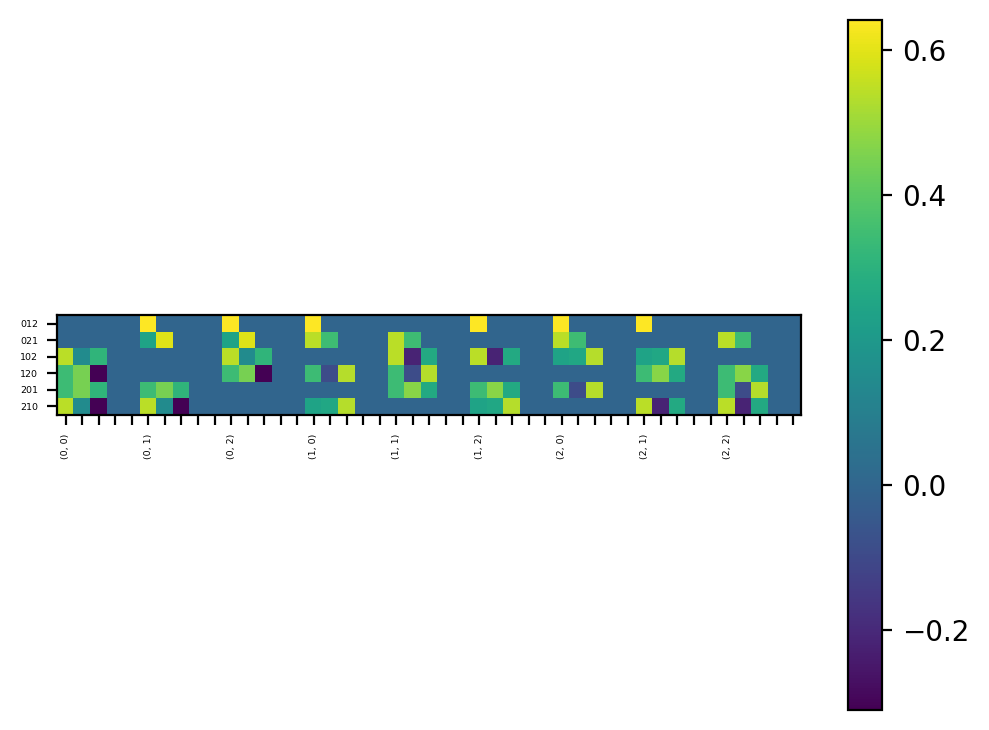

y: 45 (45,)
x: 18 18
['001', '002', '010', '011', '020', '022', '100', '101', '110', '112', '121', '122', '200', '202', '211', '212', '220', '221']
[(0, 0), '', '', '', '', (0, 1), '', '', '', '', (0, 2), '', '', '', '', (1, 0), '', '', '', '', (1, 1), '', '', '', '', (1, 2), '', '', '', '', (2, 0), '', '', '', '', (2, 1), '', '', '', '', (2, 2), '', '', '', '']
(45, 18)


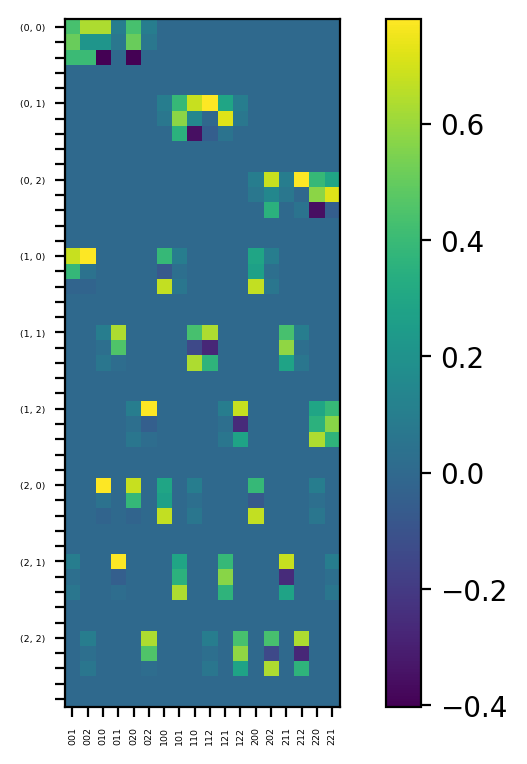

[0.49999971 0.50000032 0.49999992 0.50000077 0.49999988 0.49999994]


In [5]:

sp = sdp_to_span(X, prob)
print("yes", prob.yes_len, "no", prob.no_len)
# plt.imshow()
print(set(sp.A.flatten()))
print(set(np.array(sp.witnesses).flatten()))
# plt.imshow(np.array(sp.witnesses).T)
# plt.colorbar()kk
# plt.show()
sp.visualize_A()
sp.visualize_witnesses()
print(sp.A @ sp.witnesses[-1].T)
# print(np.array(sp.witnesses).T)
# plt.imshow(np.array(sp.witnesses) - sp.A)
# plt.colorbar()

In [22]:
A = span_from_decomp2(partials, prob)

In [23]:
print(A[0, 0,:, :])

[[0.       0.       0.       0.       0.      ]
 [0.641406 0.       0.       0.       0.      ]
 [0.641406 0.       0.       0.       0.      ]]


1.2342062164541603 0.6099251909052527
norm 6.782139417704449
len 72
rank 36 72
29.620949400000004
[(0, 0, 1), (0, 0, 2), (0, 1, 0), (0, 1, 1), (0, 2, 0), (0, 2, 2), (1, 0, 0), (1, 0, 1), (1, 1, 0), (1, 1, 2), (1, 2, 1), (1, 2, 2), (2, 0, 0), (2, 0, 2), (2, 1, 1), (2, 1, 2), (2, 2, 0), (2, 2, 1), (0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]
[(0, 0, 1), (0, 0, 2), (0, 1, 0), (0, 1, 1), (0, 2, 0), (0, 2, 2), (1, 0, 0), (1, 0, 1), (1, 1, 0), (1, 1, 2), (1, 2, 1), (1, 2, 2), (2, 0, 0), (2, 0, 2), (2, 1, 1), (2, 1, 2), (2, 2, 0), (2, 2, 1), (0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]
(6, 6)


ValueError: The number of FixedLocator locations (6), usually from a call to set_ticks, does not match the number of labels (24).

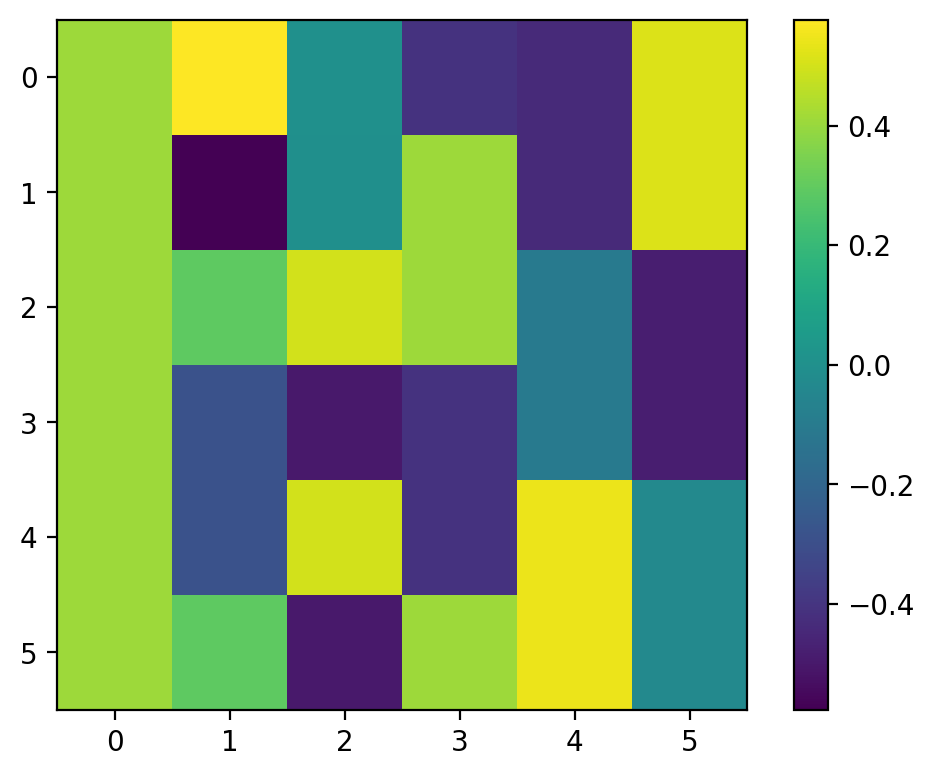

In [24]:
print(v, np.max([X[i][i] for i in range(X.shape[0])]))
print("norm", np.linalg.norm(X, 2))
print("len", X.shape[0])
print("rank", np.linalg.matrix_rank(X2), np.linalg.matrix_rank(X))
print(np.trace(X2))
evals, evects = np.linalg.eig(X2[:6, :6])
visualize(evects.real, [prob.yes_instances + prob.no_instances] * 2)

In [ ]:
print("boop1")

In [ ]:
input("bop")


def ez_space_vects(problem):
    vects = {}
    for j in range(problem.n):
        print("j", j)
        for b in problem.alphabet:
            vects[(j, b)] = []
            v = np.zeros(problem.no_len)
            for no_index in range(problem.no_len):
                no = problem.no_instances[no_index]
                if no[j] != b:
                    v[no_index] = 1

            vects[(j, b)].append(v)
    return SpanProgram(problem, vects)


input("boop")
prob = threshold_k(3, 2)
print(prob)
sp = ez_space_vects(prob)
# sp.A[0][1] = -1

In [ ]:
def find_opt_witness(span_program):
    A = span_program.A
    problem = span_program.problem
    witness_vars = [
        cp.Variable(A.shape[1]) for _ in range(span_program.problem.yes_len)
    ]
    constraints = [
        span_program.get_activated_A(x) @ witness_vars[problem.yes_instance_to_index[x]]
        == np.ones(problem.no_len)
        for x in span_program.problem.yes_instances
    ]
    for x in problem.yes_instances:
        w = witness_vars[problem.yes_instance_to_index[x]]
        for i in range(len(x)):
            for b in problem.alphabet:
                if x[i] != b:
                    constraints += [w[j] == 0 for j in span_program.I_to_mat[(i, b)]]
    opt_func = cp.Minimize(cp.max(cp.vstack([cp.norm(w, 2) for w in witness_vars])))
    opt_prob = cp.Problem(opt_func, constraints)
    opt_prob.solve(solver="SCS", verbose=True)
    return opt_prob.value, np.array([w.value for w in witness_vars]).T


v, W = find_opt_witness(sp)
print(W)
print(sp.A)
sp.visualize_A()
sp.witnesses = W
sp.visualize_witnesses()

In [ ]:
print(sp.A @ W)

In [ ]:
def special_span_sdp(problem, d):
    t = cp.Variable()
    vects = {z: [cp.Variable(d) for j in range(problem.n)] for z in problem.instances}
    constraints = []
    for yes, no in itertools.product(problem.yes_instances, problem.no_instances):
        constraints.append(
            cp.sum(
                [
                    cp.scalar_product(vects[yes][j], vects[no][j])
                    for j in range(problem.n)
                    if yes[j] != no[j]
                ]
            )
            == 1
        )

    opt_func = cp.max(
        cp.vstack(
            [
                cp.sum([vects[z][j] ** 2 for j in range(problem.n)])
                for z in problem.instances
            ]
        )
    )

    opt_prob = cp.Problem(cp.Minimize(opt_func), constraints)
    opt_prob.solve()
    return opt_prob.value, [
        [vects[z][j].value for z in problem.instances] for j in range(problem.n)
    ]


def test_sdp():
    x = cp.Variable(10)
    y = cp.Variable(10)
    z = cp.Variable(10)
    w = cp.Variable(10)
    constraints = [x >= 2, y >= 3, w >= 4, z >= 5]
    opt_prob = cp.Problem(cp.Minimize(x @ y), constraints)
    opt_prob.solve()
    # return opt_prob.valuex.value, y.value


prob = threshold_k(3, 2)

[[1.  0.5 0.5 0.5 0.5 0.5]
 [0.5 1.  0.5 1.  0.5 1. ]
 [0.5 0.5 1.  0.5 1.  1. ]
 [0.5 1.  0.5 1.  0.5 1. ]
 [0.5 0.5 1.  0.5 1.  1. ]
 [0.5 1.  1.  1.  1.  1. ]]
[[1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]]
[-0.3077061  -0.3077061   0.          0.78820544 -0.3077061  -0.3077061 ]


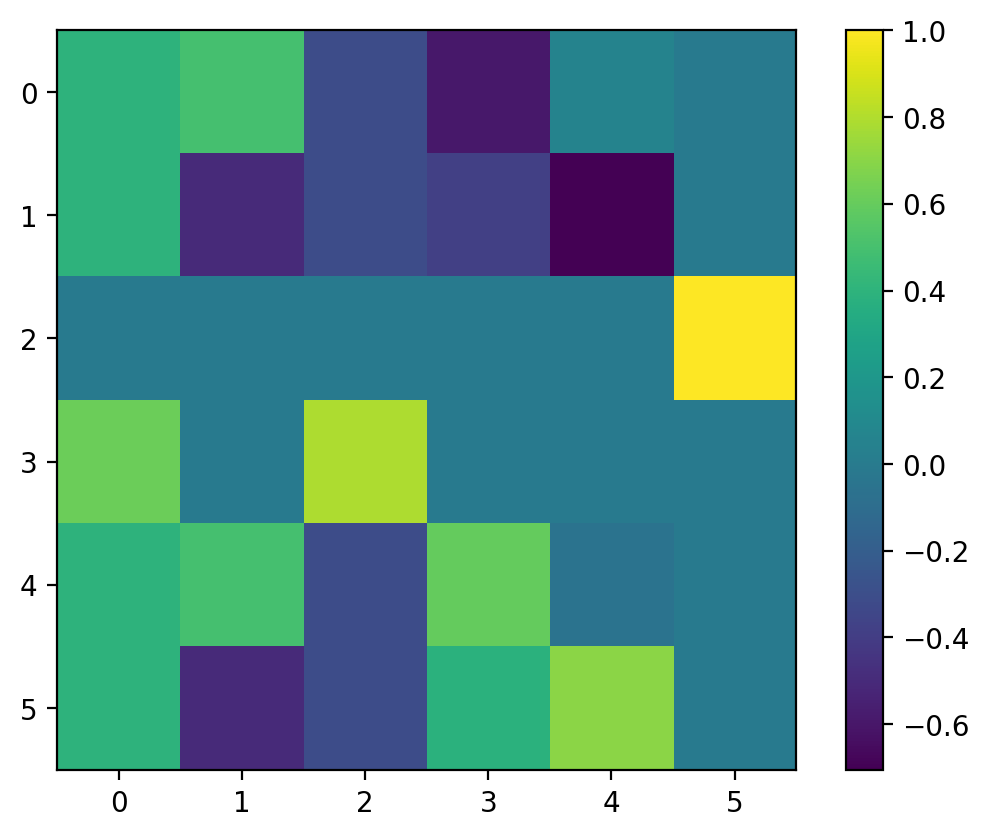

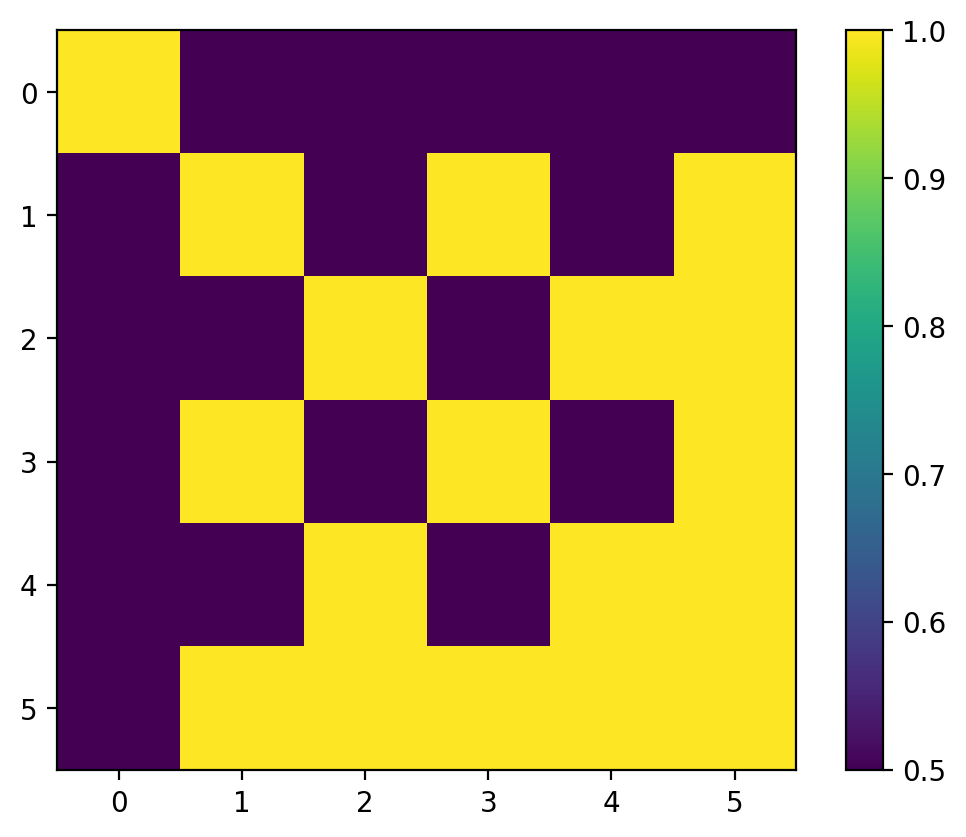

[ 4.58238560e+00  6.64077068e-01 -2.46462670e-01  1.00000000e+00
 -3.77727502e-17  8.86238777e-17]
[[1.  0.5 0.5 0.5 0.5 0.5]
 [0.5 1.  0.5 1.  0.5 1. ]
 [0.5 0.5 1.  0.5 1.  1. ]
 [0.5 1.  0.5 1.  0.5 1. ]
 [0.5 0.5 1.  0.5 1.  1. ]
 [0.5 1.  1.  1.  1.  1. ]]
[[1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]]
0
[[1.  0.5 0.5 0.5 0.5 0.5]
 [0.5 1.  0.5 1.  0.5 1. ]
 [0.5 0.5 1.  0.5 1.  1. ]
 [0.5 1.  0.5 1.  0.5 1. ]
 [0.5 0.5 1.  0.5 1.  1. ]
 [0.5 1.  1.  1.  1.  1. ]]


LinAlgError: Matrix is not positive definite

In [9]:
def dist(x, y):
    return len([j for j in range(len(x)) if x[j] == 1 and y[j] == 0])


def get_A(problem, j):
    A = np.zeros((problem.len, problem.len))
    for i in range(problem.len):
        for p in range(problem.len):
            inst1 = problem.instances[i]
            inst2 = problem.instances[p]
            if i != p:
                # print(inst1, inst2, k)
                v = len(
                    [l for l in range(n) if l != j and inst1[l] == 1 and inst2[l] == 1]
                )

                A[i, p] = v
            else:
                A[i, p] = k - 1
    return A


def get_Xj(problem, j):
    n = problem.n
    k = dist(problem.yes_instances[0], [0] * n)
    B = np.zeros((problem.len, problem.len))
    D = np.ones((problem.len, problem.len))
    for i in range(problem.len):
        for p in range(problem.len):
            inst1 = problem.instances[i]
            inst2 = problem.instances[p]
            if i != p:
                # print(inst1, inst2, k)
                v = len(
                    [l for l in range(n) if l != j and inst1[l] == 1 and inst2[l] == 1]
                )

                B[i, p] = 1 / (k - v)
            else:
                B[i, p] = 1

    for yes1 in problem.yes_instances:
        yes_index1 = problem.instance_to_index[yes1]
        for yes2 in problem.yes_instances:
            if yes1 != yes2:
                yes_index2 = problem.instance_to_index[yes2]
                D[yes_index1, yes_index2] = np.sqrt((n - k + 1) / k)

        # for no in problem.no_instances:
        #     no_index = problem.instance_to_index[no]
        #     if no[j] == 0 or (no[j]==1 and yes1[j]==1):
        #         B[yes_index1, no_index] = 0
        #         B[no_index, yes_index1] = 0

    for no1 in problem.no_instances:
        no_index1 = problem.instance_to_index[no1]
        for no2 in problem.no_instances:
            if no1 != no2:
                no_index2 = problem.instance_to_index[no2]
                D[no_index1, no_index2] = np.sqrt(k / (n - k + 1))

    print(B)
    print(D)
    return np.multiply(B, D)


n = 3
k = 2
prob = threshold_k(n, k)
Xj = get_Xj(prob, 0)
A = get_A(prob, 1)
vals, vects = np.linalg.eig(A)
print(vects[:, 2])
plt.imshow(np.array(vects))
plt.colorbar()
plt.show()
L = np.linalg.cholesky(A + 2 * np.eye(prob.len))
plt.imshow(Xj)
plt.colorbar()
plt.show()
print(np.linalg.eigvals(Xj))
X = np.zeros((n * prob.len, n * prob.len))


for i in range(n):
    X = get_Xj(prob, i)
    print(i)
    print(X)
    X[i * prob.len : (i + 1) * prob.len, i * prob.len : (i + 1) * prob.len] = Xj
    print(np.linalg.cholesky(Xj + 0.01 * np.eye(prob.len)))


plt.imshow(np.linalg.cholesky(X + 0.001 * np.eye(n * prob.len)))

In [ ]:
X2 = X
# print(X)
L = get_cholesky_fact(X2)
print(L)
partials = decompose_cholesky(L.T, prob)
# print(partials[0].shape)
# plt.imshow(L.T)
# plt.show()
# print(sp.A)
# for partial in partials:
# plt.imshow(partial)
# plt.colorbar()
# plt.show()
# plt.imshow()
sp = span_from_decomp(partials, prob)
# plt.imshow()
print(set(sp.A.flatten()))
plt.imshow(np.array(sp.witnesses).T)
plt.colorbar()
plt.show()
sp.visualize_A()
sp.visualize_witnesses()
print(np.array(sp.witnesses).T)

In [ ]:
list(itertools.combinations([(1, 2), (3, 4)], 2))

In [10]:
v = np.zeros(5)

In [11]:
v[(1,2)]

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [12]:
y = np.random.rand(5)
M = np.random.rand(12).reshape((2,2,3))
print(y)
print(M)

[0.99743696 0.58258382 0.87378323 0.19359625 0.11776938]
[[[0.72705137 0.52883444 0.73604979]
  [0.48958826 0.61087555 0.03620873]]

 [[0.85919332 0.46067814 0.72455608]
  [0.00736044 0.7214586  0.88332417]]]


In [13]:
Z = np.tensordot(y.T, M, 0)

In [14]:
print(Z.shape)
print(Z[0,0, :, :])

(5, 2, 2, 3)
[[0.72518791 0.52747902 0.73416327]
 [0.48833343 0.60930986 0.03611592]]


In [15]:
def visualize_partial_span(span_program, problem, no_index, j, b):
    A = copy(span_program.A)
    
    B=A.reshape((problem.no_len, problem.n, len(problem.alphabet), -1))
    d = B.shape[-1]
    plt.imshow(B[no_index, j, :,:])
    plt.colorbar()
    plt.show()
    
def visualize_partial_witness(span_program, problem, yes_index, j):
    # print(yes_index, "blah")
    Y = np.array(span_program.witnesses).T.reshape((problem.yes_len, problem.n, len(problem.alphabet), -1))
    # to_remove = problem.alphabet.index(problem.yes_instances[yes_index][j])
    # to_remove_index = np.zeros(len(problem.alphabet))
    # to_remove_index[to_remove] = 1
    # Y= delete()
    visualize(Y[yes_index, j, :, :], (list(range(Y.shape[-1])), to_str(problem.alphabet)))
    # plt.plot()
    # plt.show()

yes instance (0, 1, 1)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44]
01
(2, 45)


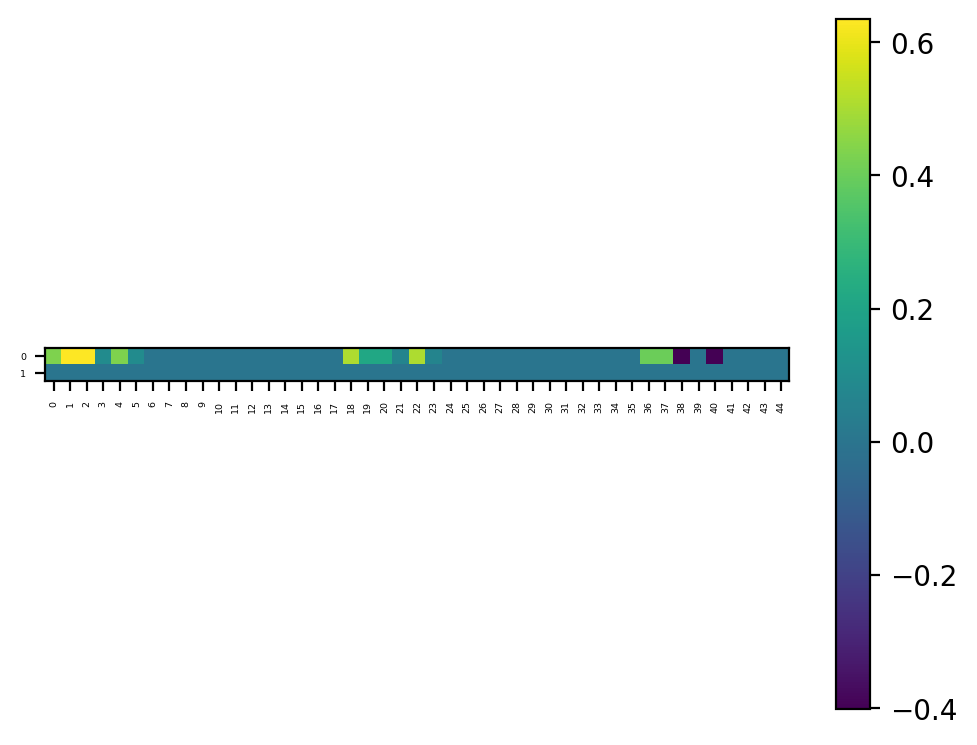

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44]
01
(2, 45)


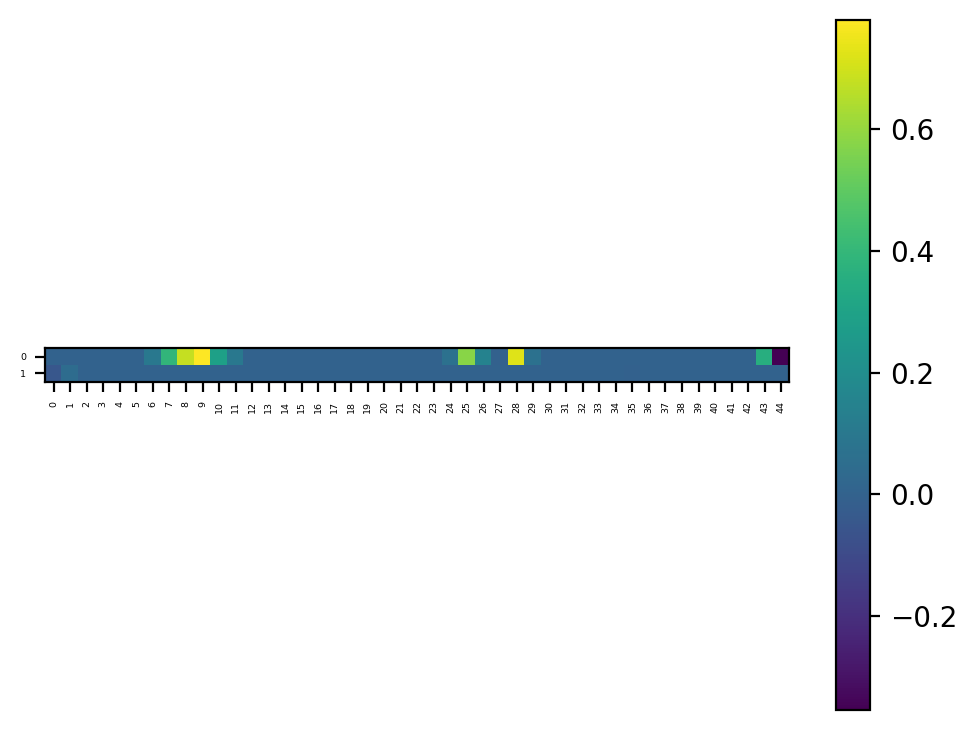

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44]
01
(2, 45)


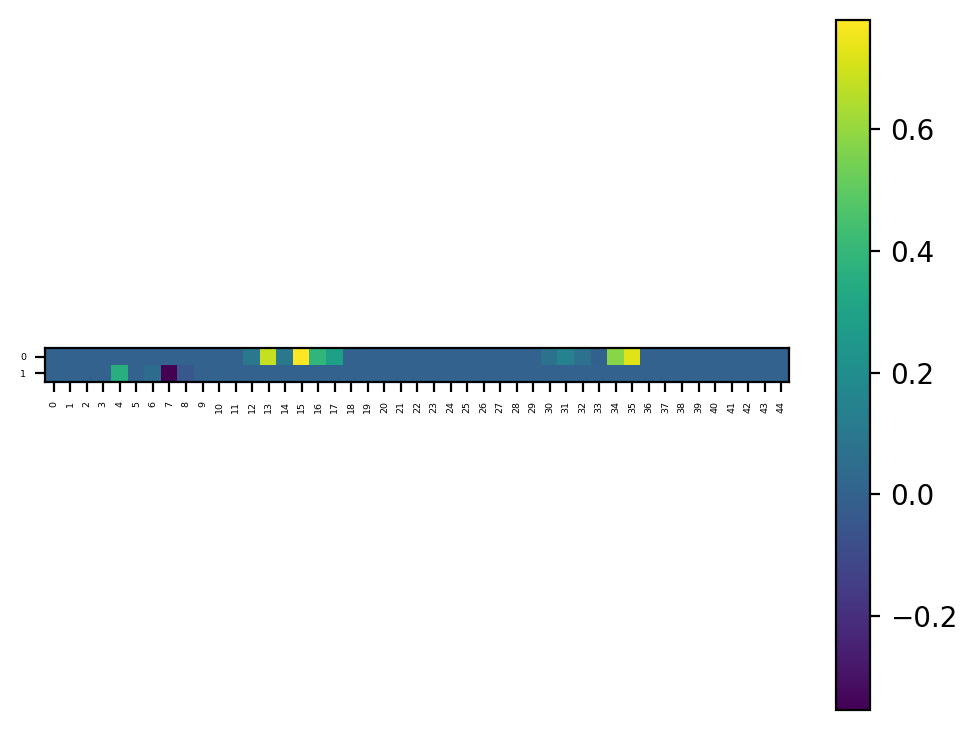

yes instance (1, 0, 1)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44]
01
(2, 45)


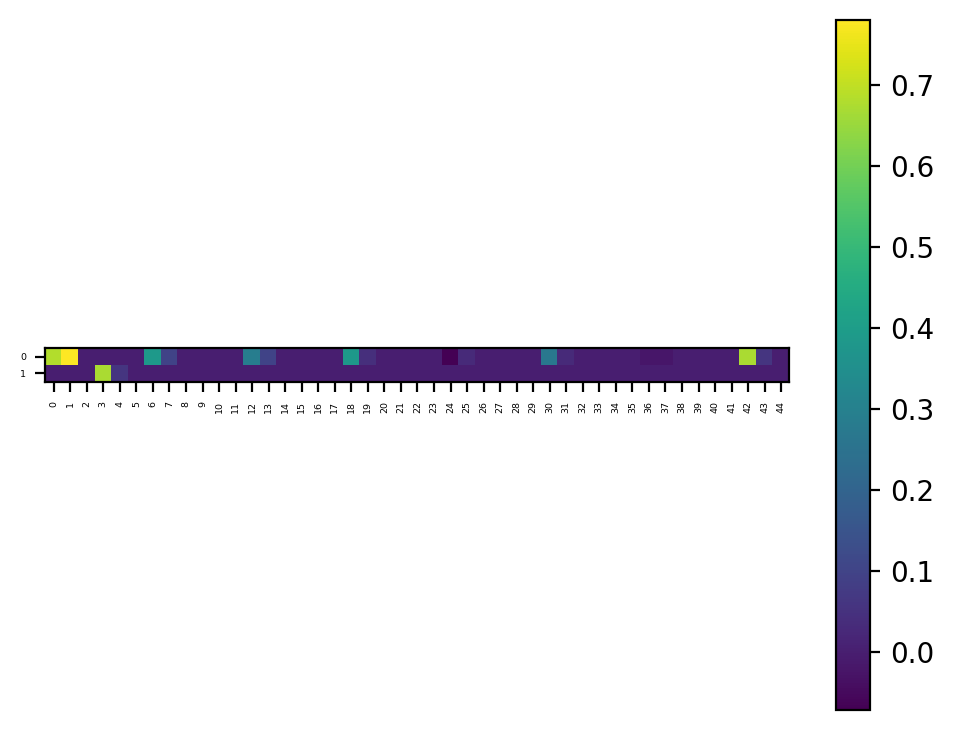

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44]
01
(2, 45)


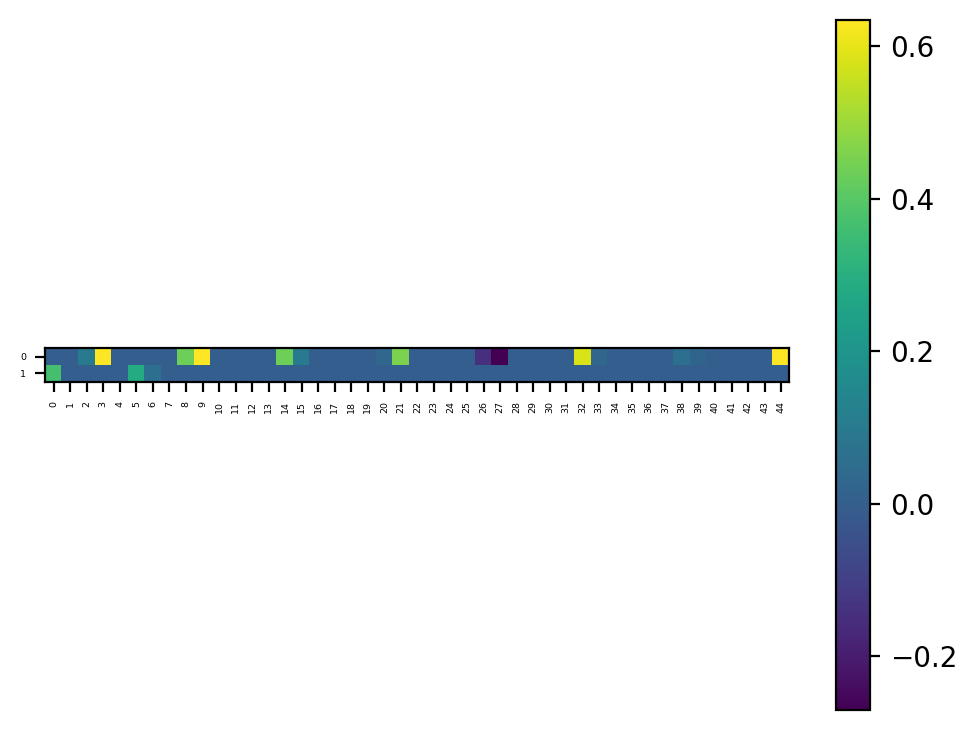

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44]
01
(2, 45)


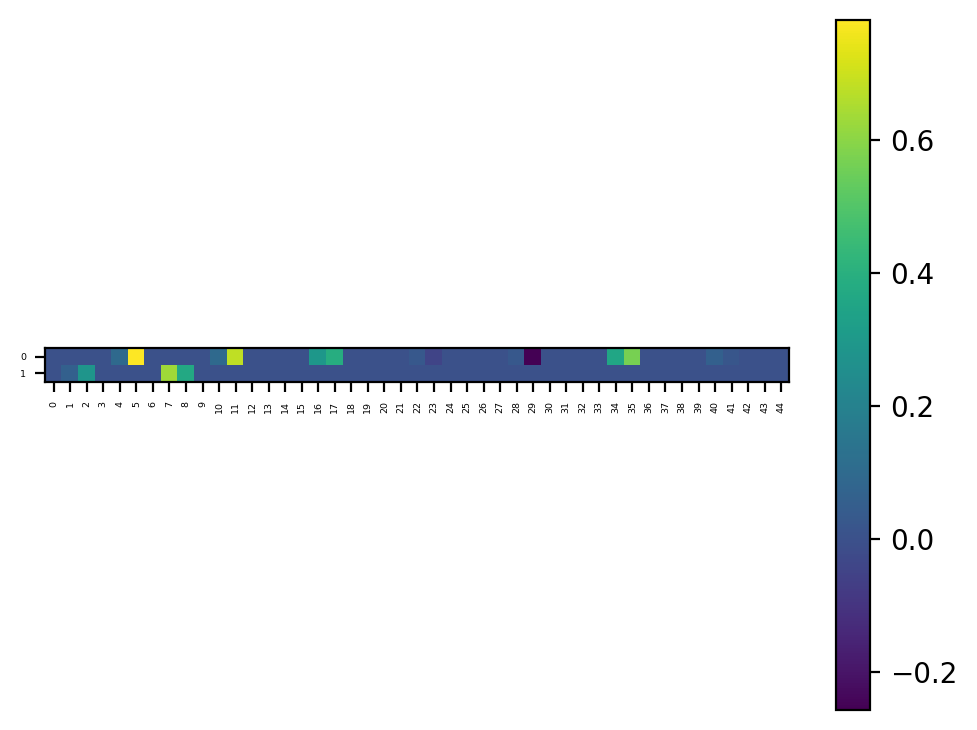

yes instance (1, 1, 0)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44]
01
(2, 45)


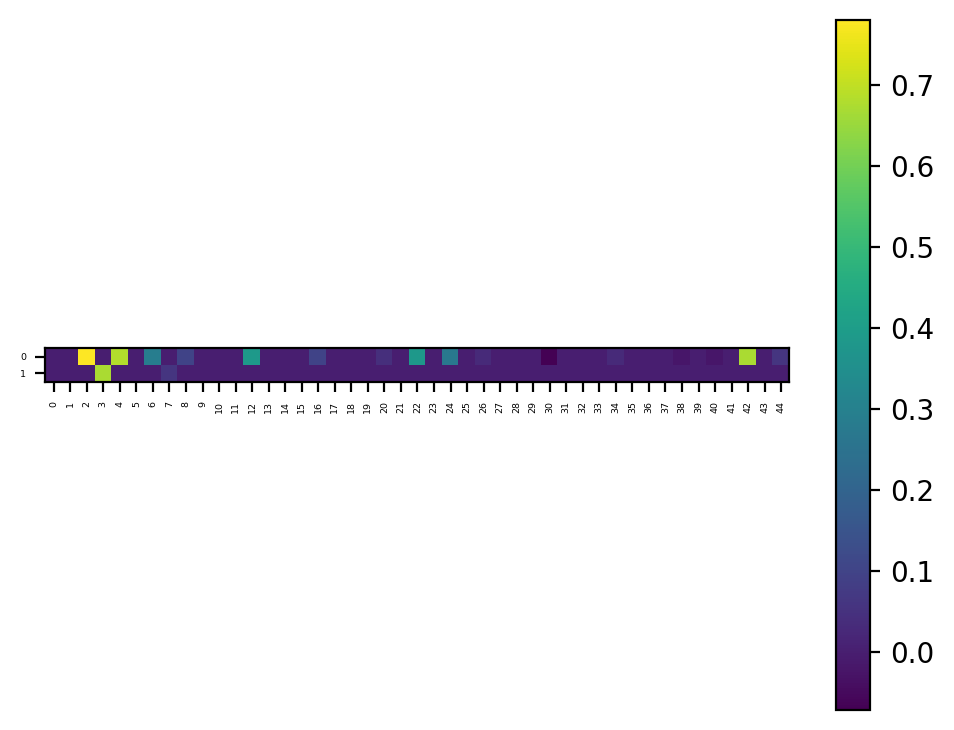

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44]
01
(2, 45)


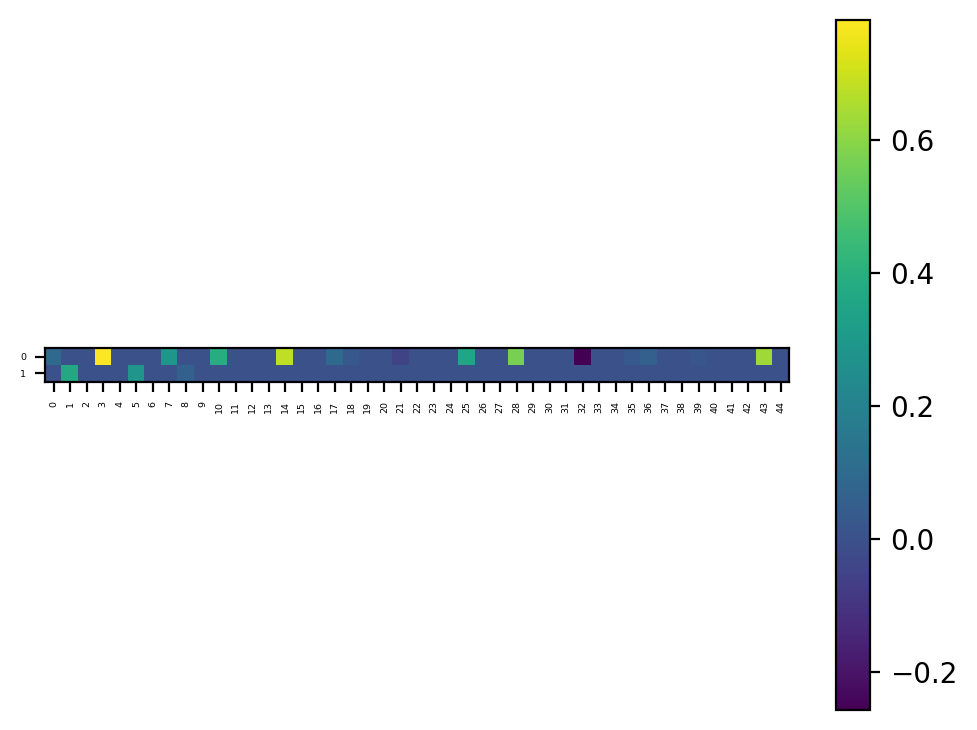

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44]
01
(2, 45)


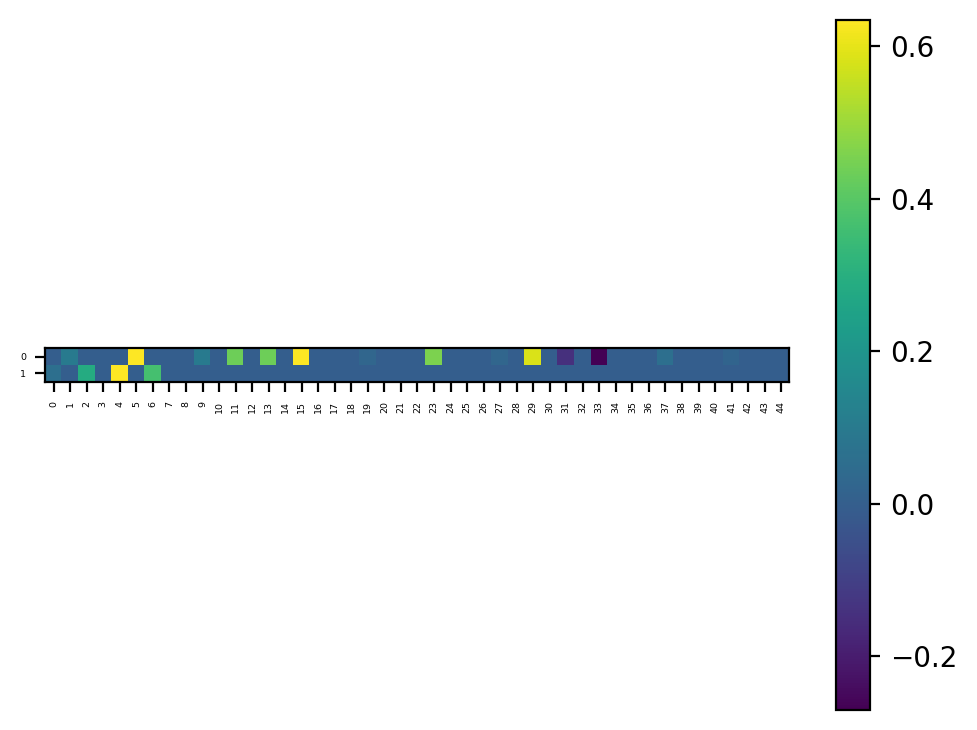

no_instance (0, 0, 1)


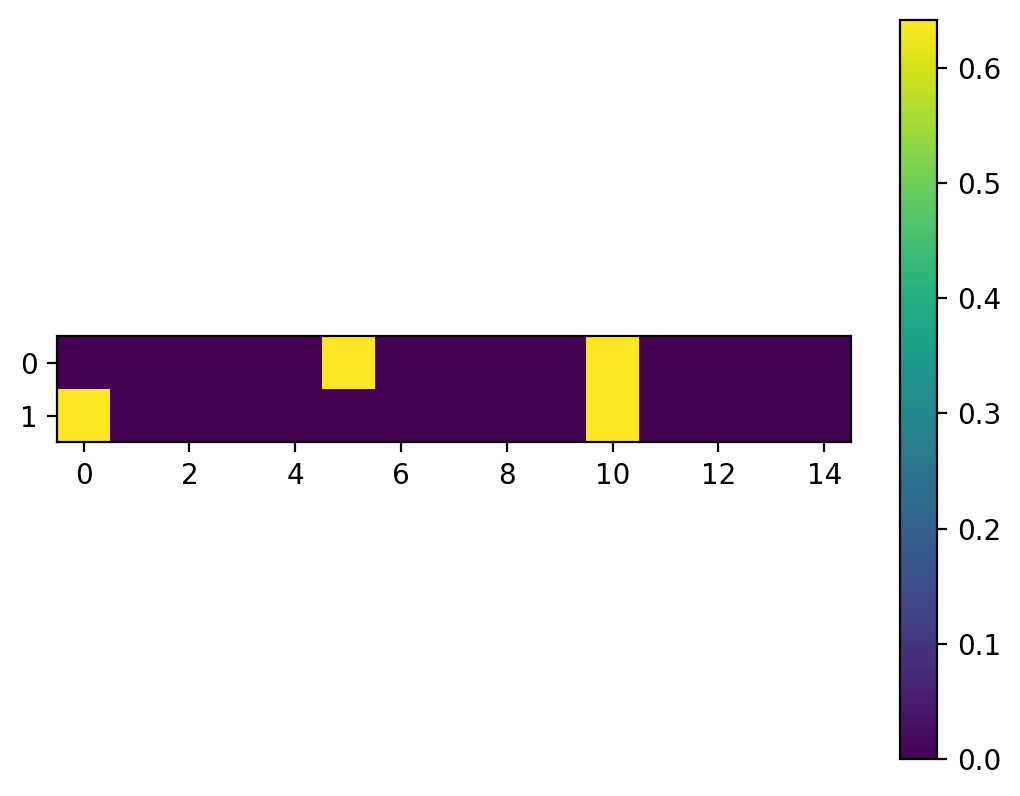

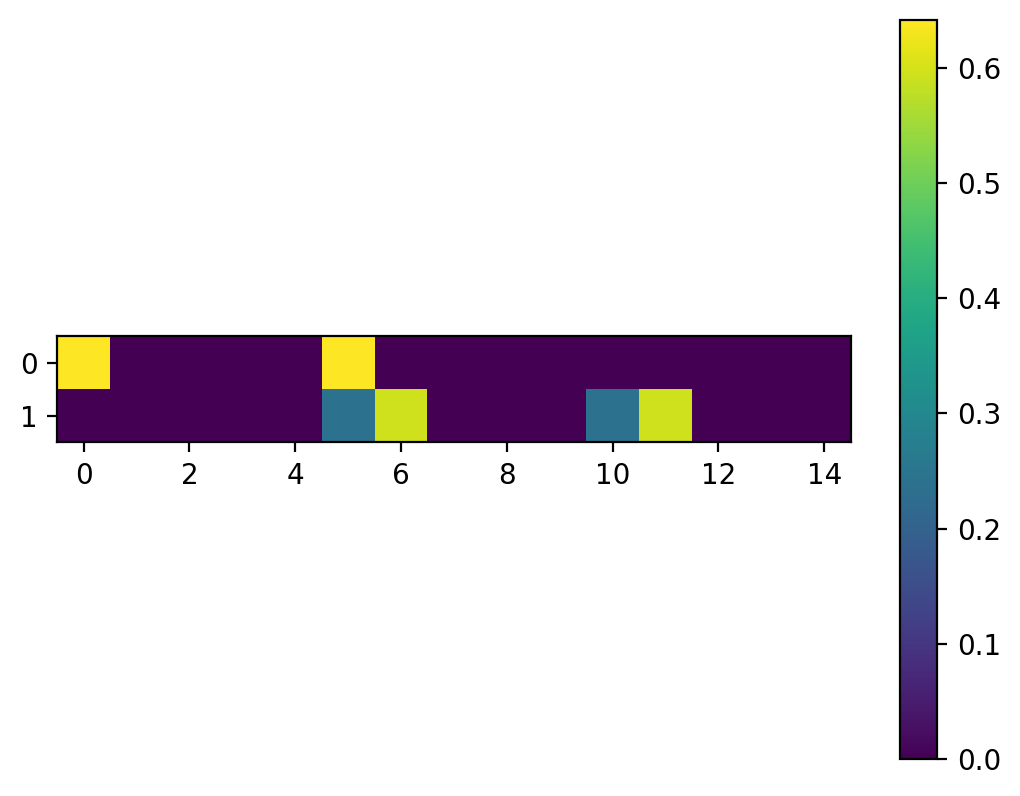

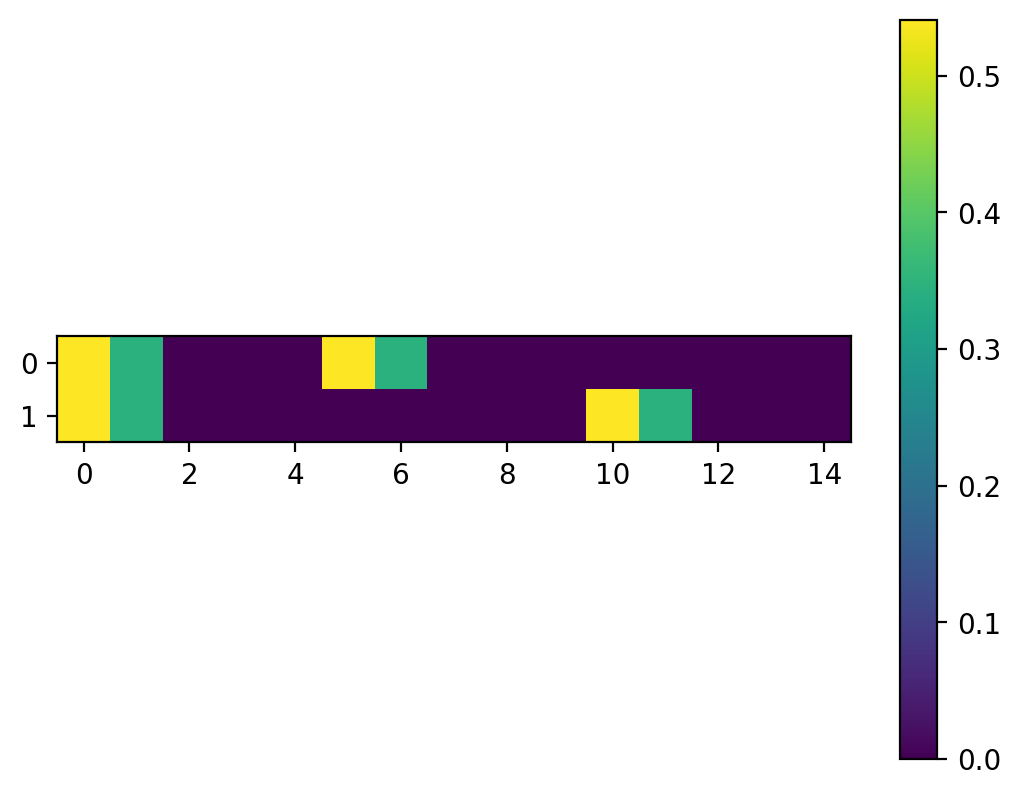

no_instance (0, 1, 0)


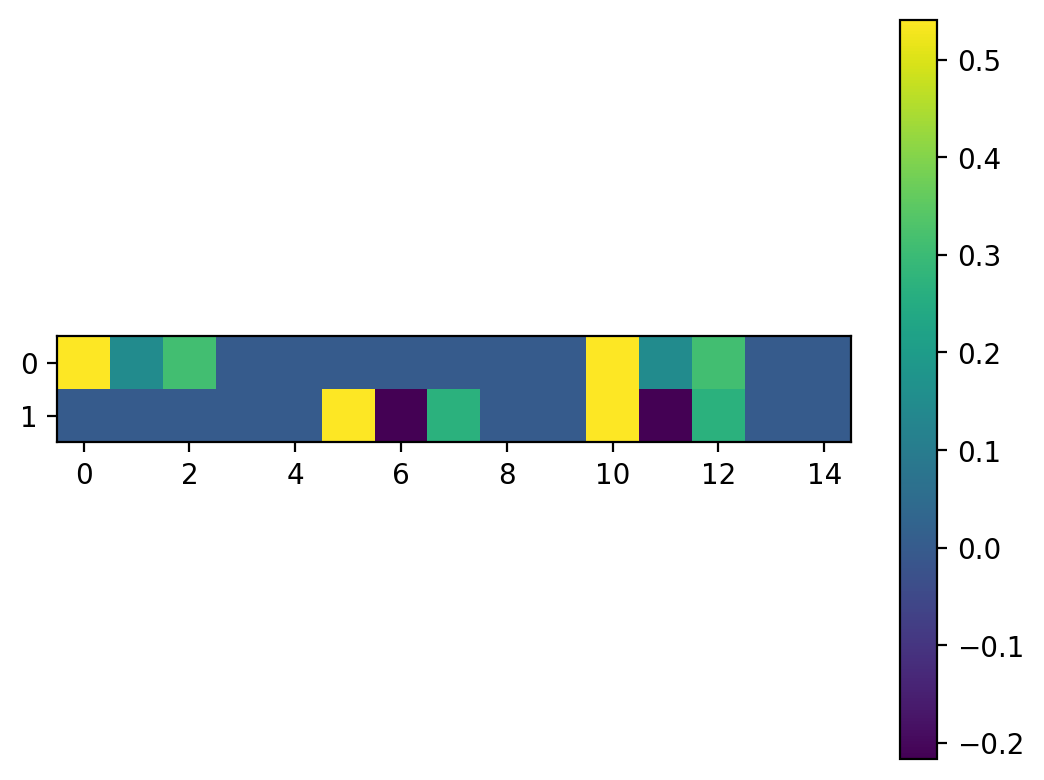

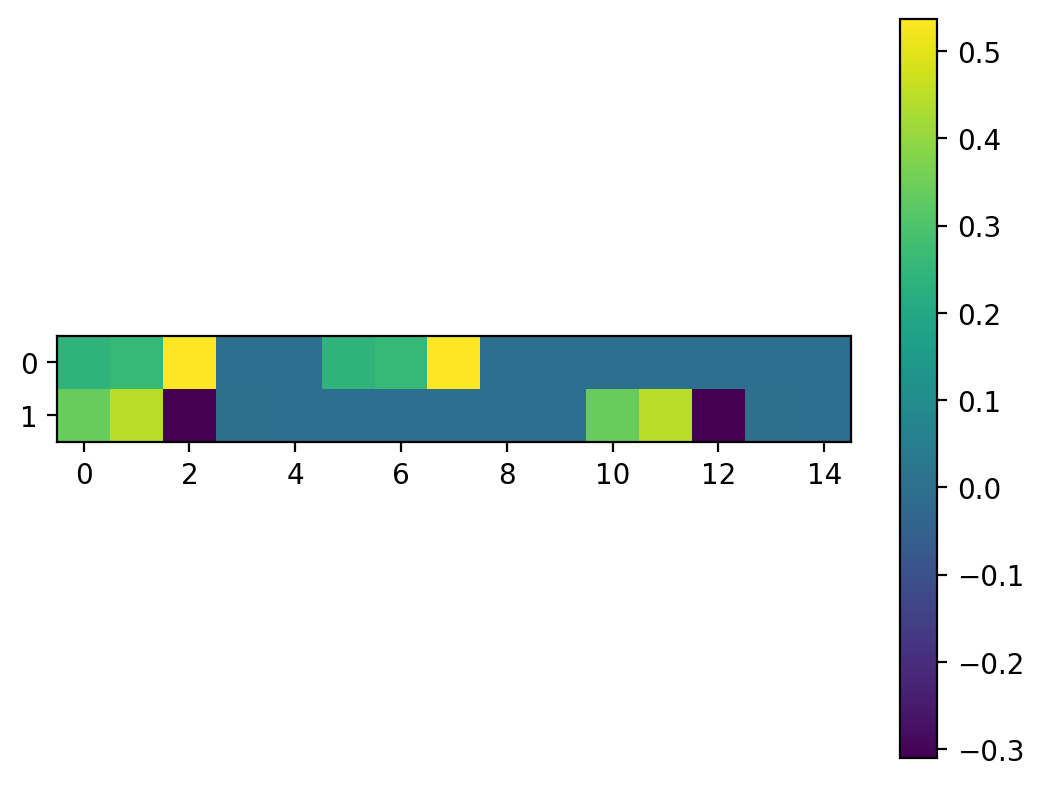

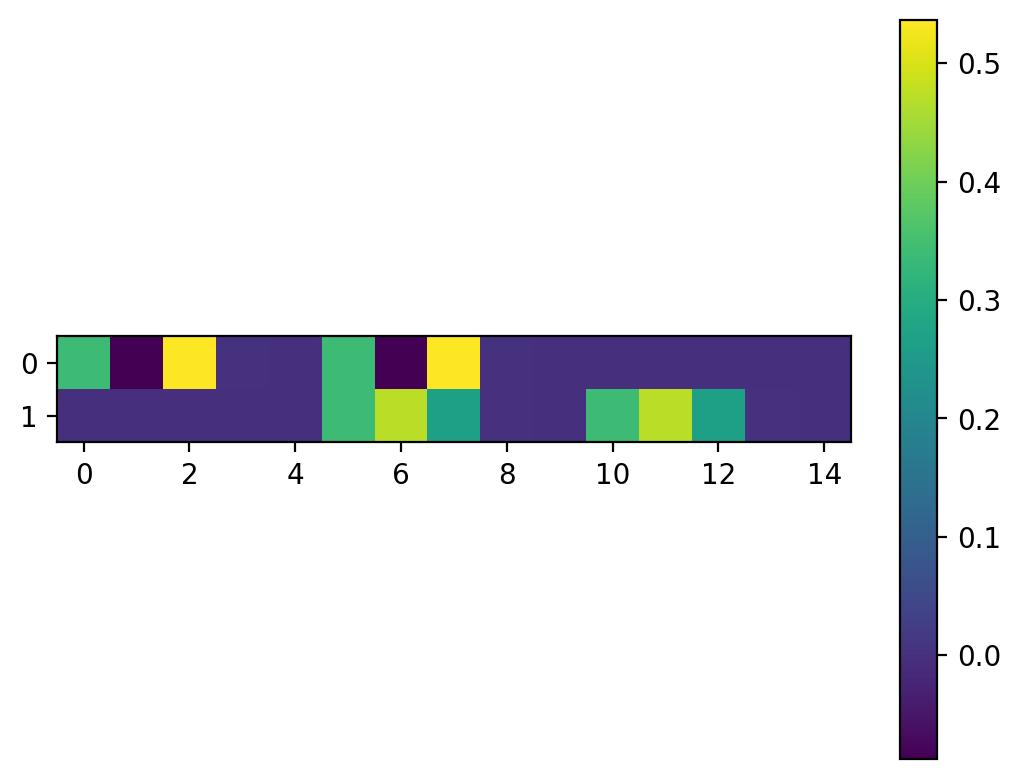

no_instance (1, 0, 0)


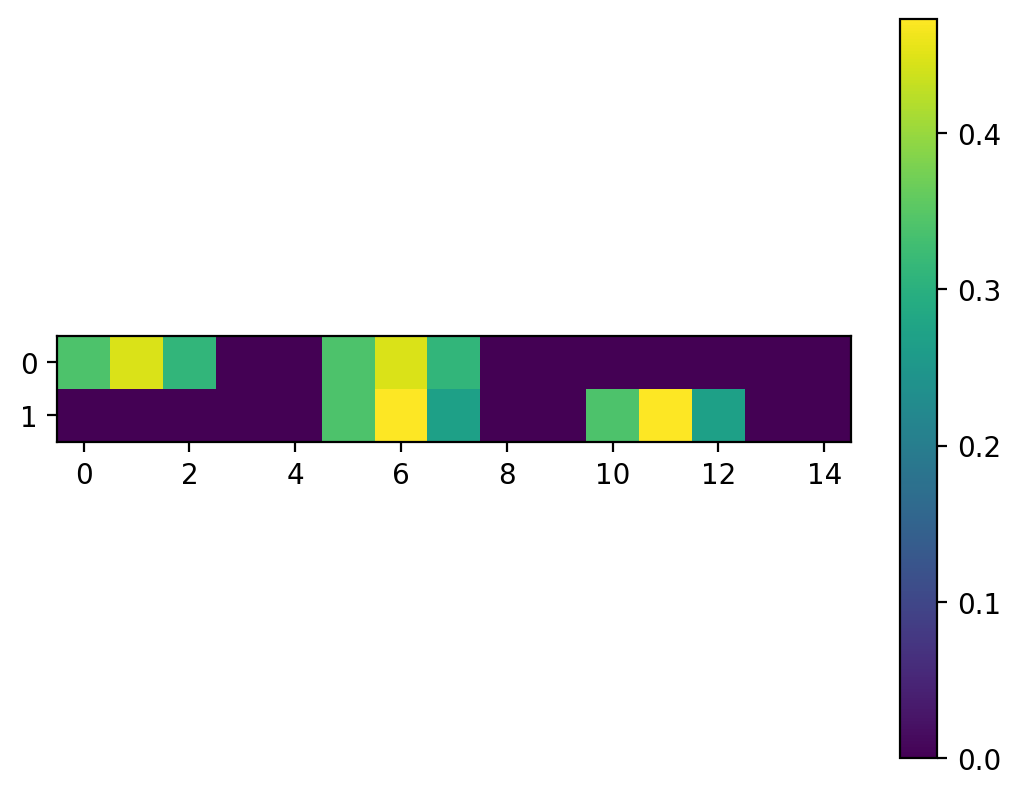

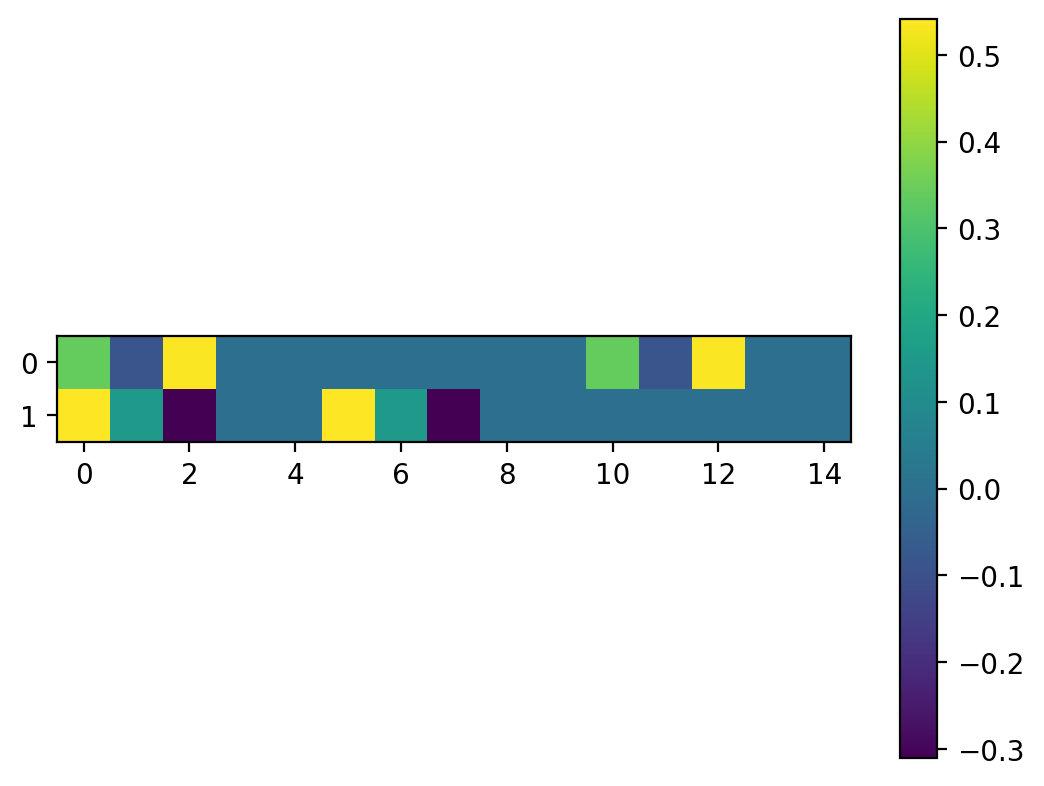

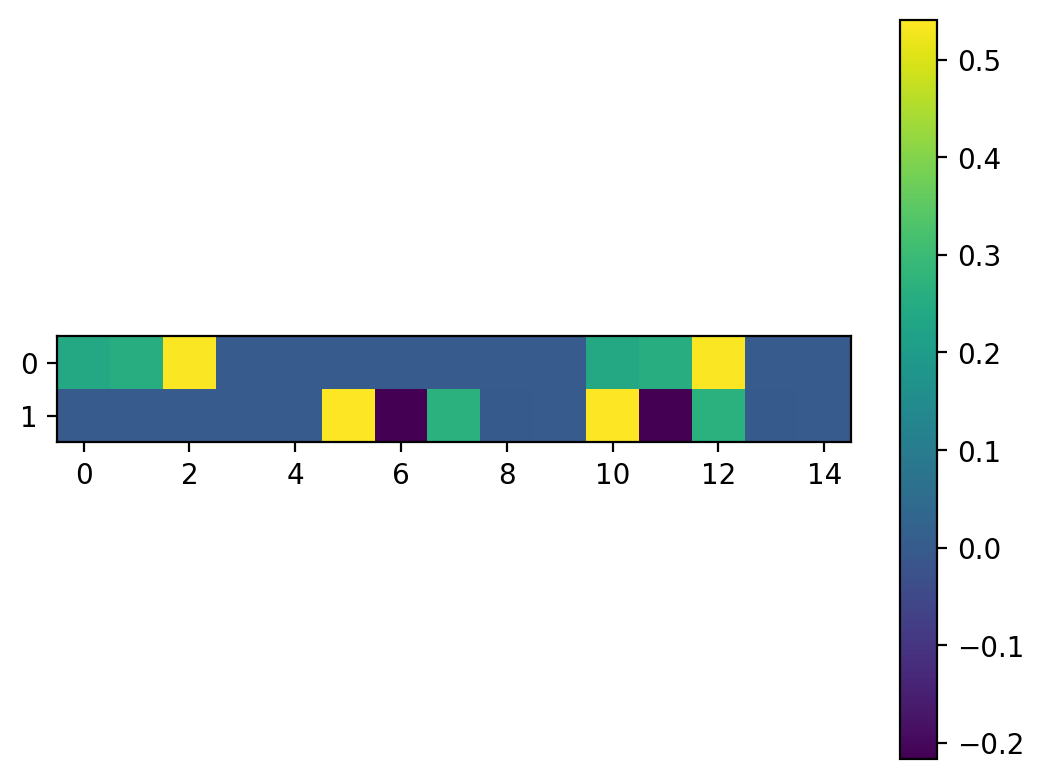

In [16]:
for yes_index in range(prob.yes_len):
    print('yes instance',prob.yes_instances[yes_index])
    for j in range(prob.n):
        visualize_partial_witness(sp, prob, yes_index,j)


for no_index in range(prob.no_len):
    print('no_instance', prob.no_instances[no_index])
    for j in range(prob.n):
        visualize_partial_span(sp, prob, no_index,j,0)